In [1]:
from typing import Callable

import diffrax
import jax
import jax.numpy as jnp
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
from pysindy import STLSQ
from pysindy.utils import van_der_pol
from scipy.integrate import solve_ivp
from tqdm import tqdm

from exp.expdata import GenExAdapter
from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings, AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from jsindy.kernels import ConstantKernel, ScalarMaternKernel

from confplot import *

/home/jmsh/github/jsindy/env/lib/python3.13/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()


In [2]:
jax.default_device(jax.devices()[1])

In this experiment, we know we can get correct answer with t1=100 and n_train=50 and the ActiveSetOptimizer
Let's try to find how well we can do as we decrease the amount of training data, modifying

`noise`, `t`, `n_train`, and whether we're using annealing

In [3]:
noise = 0.1
t1 = 100
n_train = 50
annealing = False

## Generate Data

dt_train=2.0
Noise std deviation is 7.72% training data std deviation


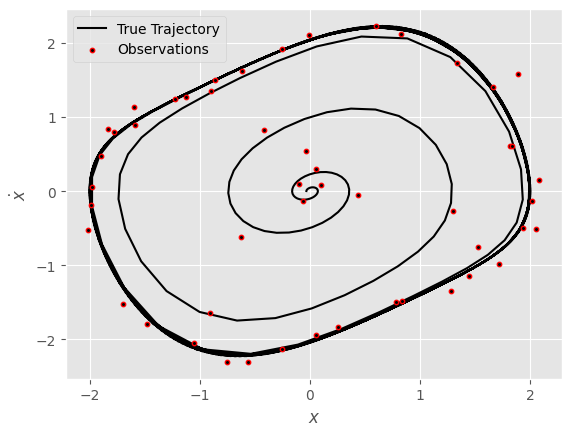

In [4]:
expdata = GenExAdapter(
    system="vdp",
    t0=0.,
    ic_std=0.02,
    t1=2 * t1,
    noise=noise,
    n_train=2 * n_train,
    n_colloc=1000,
    seed=1234
)
true_midpoint = len(expdata.x_true) // 2
train_midpoint = len(expdata.x_train) // 2
x_true = expdata.x_true[:true_midpoint]
t_true = expdata.t_true[:true_midpoint]
t_extend = expdata.t_true[true_midpoint:]
x_true_extend = expdata.x_true[true_midpoint:]
t_colloc = expdata.t_colloc[:true_midpoint]

t_train = expdata.t_train[:train_midpoint]
x_train = expdata.x_train[:train_midpoint]
t_train.shape
print(f"dt_train={t1/n_train}")
print(f"Noise std deviation is {100 * noise / np.std(x_true):.2f}% training data std deviation")
plt.plot(x_true[:,0], x_true[:,1], **TRUE_KW)
plt.xlabel(r"$x$")
plt.ylabel(r"$\dot x$")
plt.scatter(x_train[:,0], x_train[:,1], **OBS_KW)
plt.legend()
None

## Define Model Parameters

In [5]:
kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=2.0)
)   

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=3)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
sparsifier = pySindySparsifier(STLSQ(threshold = 0.25,alpha = 0.01))

if not annealing:
    optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=1e5,
        fixed_data_weight=1,
        sparsifier = sparsifier,
    )
else:
    optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=1e5,
        fixed_data_weight=1,
        sparsifier = sparsifier,
        num_annealing_steps=4,
    )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    input_orders=(0, 1),
    ode_order=2,
    feature_names=['x']
)

## Fit the model

In [6]:
model.fit(t_train, x_train[:, :1], t_colloc)

print("True model:")
expdata.print()
print("Discovered model:")
model.print()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.12054733e-08, dtype=float64), 'data_weight': 1, 'colloc_weight': 100000.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 48.69, gradnorm = 7.068e+03, alpha = 4.167, improvement_ratio = 0.9596
Iteration 1, loss = 1.122, gradnorm = 3.19e+03, alpha = 3.472, improvement_ratio = 0.9892
Iteration 2, loss = 0.5647, gradnorm = 697.5, alpha = 2.894, improvement_ratio = 0.9239
Iteration 3, loss = 0.502, gradnorm = 248.9, alpha = 2.894, improvement_ratio = 0.7811
Iteration 4, loss = 0.4735, gradnorm = 176.7, alpha = 2.411, improvement_ratio = 0.9007
Iteration 5, loss = 0.4641, gradnorm = 78.07, alpha = 2.009, improvement_ratio = 0.9071
Line Search Failed!
Final Iteration Results
Iteration 61, loss = 0.3606, gradnorm = 6.457e-07, alpha = 0.7342, improvement_ratio = -2.488e+03
Model after smooth warm start
(x)'' = -0.011 1 + -1.087 x + 0.479 (x') + -0.008 x^2 + -0.004 x (x') + 0.010 (x')^2 + 0.028 x^3 + -0.320 x^2 (x') + 0.040 x (x')^2 + -0.056 (x')^3
Alternating Activeset Sparsifier
7 active coeffs changed
Active set stabilized
True model:
x' = 1 x'
x'' = -1 x + 0.5 x' + -0.5 x^2 x'
Discovered mo

In [7]:
x_pred = model.predict_state(t_true)
xdot_pred = model.traj_model.derivative(t_true,model.z,diff_order = 1)

def model_ode(t,x,args = None):
    return jnp.array([jnp.array([x[1]]), model.predict(x)]).flatten()

def vdp_ode(t,x,args = None):
    return jnp.array([x[1], van_der_pol(t, x)[1]]).flatten()

y0 = x_true[-1]

def extend(rhs: Callable, t_extend: jax.Array, y0: jax.Array):
    dt = t_extend[1] - t_extend[0]
    t1 = t_extend[-1]
    t0 = t_extend[0]
    stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
    sol = diffrax.diffeqsolve(
        terms = diffrax.ODETerm(rhs),
        solver = diffrax.Tsit5(),
        t0=t0,
        t1=t1,
        dt0 = dt,
        y0 = y0,
        saveat = diffrax.SaveAt(ts=t_extend),
        stepsize_controller=stepsize_controller,
        max_steps = int(10*(t1-t0)/dt),
    )

    return sol.ys

x_sim = extend(model_ode, t_extend, y0)


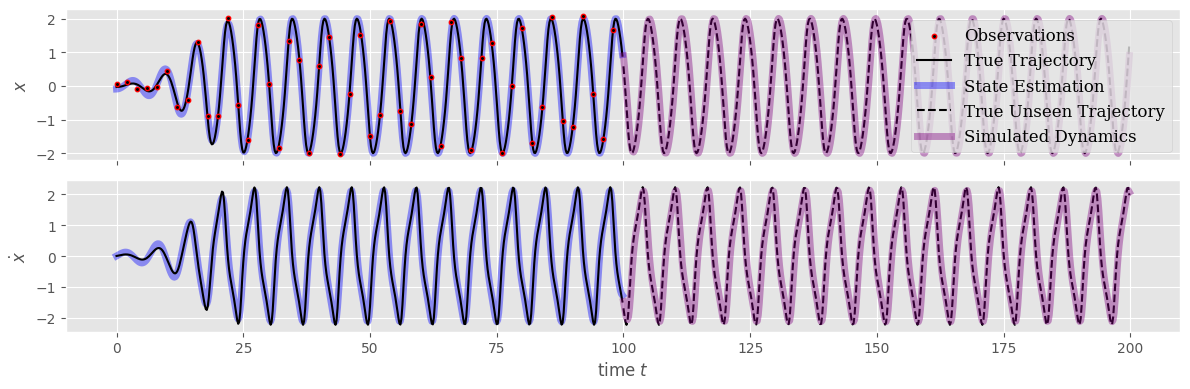

In [45]:

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,4), sharex=True)

fontname = 'serif'

ax1.scatter(t_train, x_train[:,0], **OBS_KW)
ax1.plot(t_true, x_true[:,0], **TRUE_KW)
ax1.plot(t_true, x_pred, **EST_KW)
ax1.plot(t_extend, x_true_extend[:, 0], **TRUE_UNS_KW)
ax1.plot(t_extend, x_sim[:, 0], **SIM_KW)

ax1.set_ylabel(r"$x$", fontname=fontname,size=12)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], **TRUE_KW)
ax2.plot(t_true, xdot_pred, **EST_KW)
ax2.plot(t_extend, x_true_extend[:, 1], **TRUE_UNS_KW)
ax2.plot(t_extend, x_sim[:, 1], **SIM_KW)

ax2.set_ylabel(r"$\dot x$", fontname=fontname,size=12)
ax2.set_xlabel(r"time $t$")
ax2.grid(True)
# ax2.legend(prop={'family': fontname, 'size':12})

plt.tight_layout()
plt.savefig("vdp_time.pdf")

In [13]:
print(x_true[0])

[-0.03207674  0.001282  ]


In [14]:
n_points = 221
x_max = 5
x_min = -5

y_max = 5
y_min = -5
x_vals = np.linspace(x_min, x_max, n_points)
y_vals = np.linspace(y_min, y_max, n_points)

X0, Y0 = np.meshgrid(x_vals, y_vals)
U = np.zeros(X0.shape)
V = np.zeros(Y0.shape)
Uj = np.zeros(X0.shape)
Vj = np.zeros(Y0.shape)

# Evaluate the vector field
for i in tqdm(range(X0.shape[0])):
    for j in range(X0.shape[1]):
        arr = [X0[i, j], Y0[i, j]]
        dxdt, dydt = van_der_pol(0, arr,)
        U[i, j] = dxdt
        V[i, j] = dydt

        dxdt, dydt = arr[1], model.predict(jnp.array(arr))[0]
        Uj[i, j] = dxdt
        Vj[i, j] = dydt

# Normalize the arrows
speed = np.sqrt(U**2 + V**2)
U /= speed
V /= speed


speed = np.sqrt(Uj**2 + Vj**2)
Uj /= speed
Vj /= speed

100%|██████████| 221/221 [00:40<00:00,  5.48it/s]
/tmp/ipykernel_765508/1596098652.py:30: RuntimeWarning: invalid value encountered in divide
  U /= speed
/tmp/ipykernel_765508/1596098652.py:31: RuntimeWarning: invalid value encountered in divide
  V /= speed
/tmp/ipykernel_765508/1596098652.py:35: RuntimeWarning: invalid value encountered in divide
  Uj /= speed
/tmp/ipykernel_765508/1596098652.py:36: RuntimeWarning: invalid value encountered in divide
  Vj /= speed


In [15]:
initial_conditions = [
    jnp.array([3.,3.]),
    jnp.array([0.5,0.4]),
    jnp.array(([-4.,2.])),
    jnp.array([2.,-3.]),
    jnp.array([-4.,-3.]),
]

true_traj = []
sim_traj = []
for y0 in tqdm(initial_conditions):
    sim_traj.append(extend(model_ode, t_true, y0))
    true_traj.append(extend(vdp_ode, t_true, y0))

100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


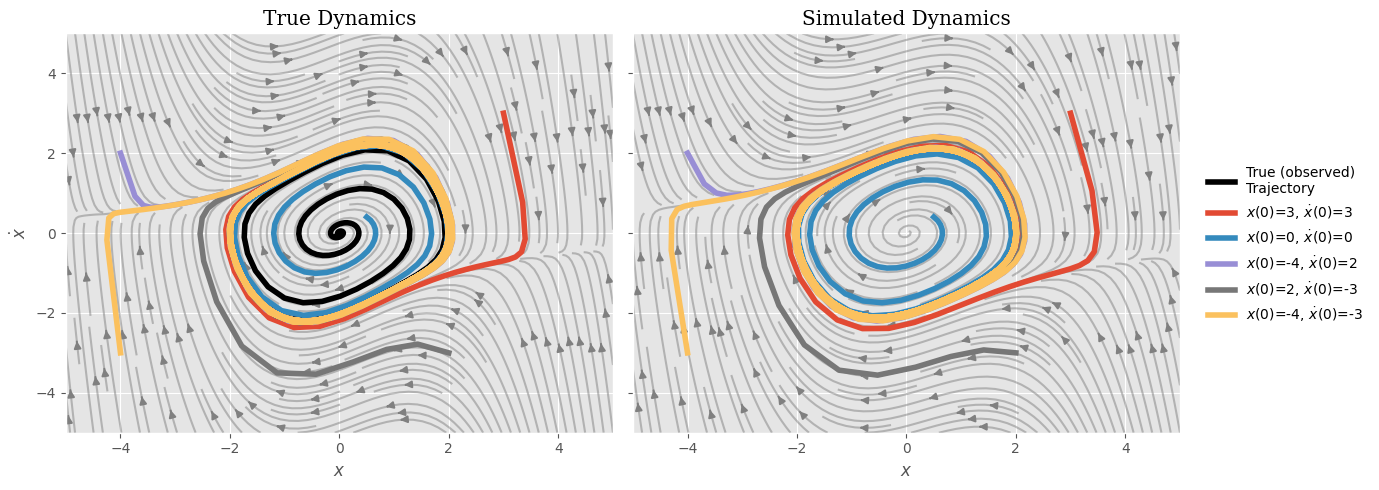

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5),sharey=True)
axs = axs.flatten()

sp0 = axs[0].streamplot(x_vals, y_vals, U, V, density=2, color='gray')
axs[0].plot(x_true[:150, 0], x_true[:150, 1], **(TRUE_KW | {"lw": 4, "zorder": 2, "label": "True (observed)\nTrajectory"}))
axs[0].set_ylabel(r"$\dot x$")
axs[0].set_xlabel(r"$x$")
axs[0].set_title("True Dynamics",family='serif')

# Change alpha for both lines and arrows
sp0.lines.set_alpha(0.5)
sp0.arrows.set_alpha(0.5)

cutoff=-1
cutoffs = [1080, 1000,1150,1250,1050]
sp1 = axs[1].streamplot(x_vals, y_vals, Uj, Vj, density=2, color='gray')


# Plot trajectories 
for idx, (x_true_i,x_pred_i) in enumerate(zip(true_traj,sim_traj)):

    cutoff = cutoffs[idx]

    c=None
    ic = initial_conditions[idx]
    label = rf"$x(0)$={int(ic[0])}, $\dot x(0)$={int(ic[1])}"
    axs[0].plot(x_true_i[:,0],x_true_i[:,1],
                lw=4,zorder=2,c=c,label=label)

    axs[1].plot(x_pred_i[:cutoff,0],x_pred_i[:cutoff,1],
                lw=4,zorder=2,c=c)

axs[1].set_xlabel(r"$x$")
axs[1].set_title("Simulated Dynamics", family='serif')

axs[0].set_xlim(x_min,x_max)
axs[1].set_xlim(x_min,x_max)

axs[0].set_ylim(y_min,y_max)
axs[1].set_ylim(y_min,y_max)


# Change alpha for both lines and arrows
sp1.lines.set_alpha(0.5)
sp1.arrows.set_alpha(0.5)


fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)

plt.tight_layout()

plt.savefig("vdp_true_phase.pdf", bbox_inches="tight")

## Traditional and Weak SINDy

In [26]:
diff = ps.SINDyDerivative(kind="kalman")
lib = ps.PolynomialLibrary(3)
trad_model = ps.SINDy(differentiation_method=diff, feature_library=lib, optimizer=ps.MIOSR(target_sparsity=4))
trad_model.fit(np.array(x_train), np.array(t_train), feature_names=["x", "x'"])
print("Decent SINDy with direct x_dot measurements")
trad_model.print()

trad_ho_model = ps.SINDy(differentiation_method=diff, feature_library=lib, optimizer=ps.MIOSR(target_sparsity=3))
x_dot_est = diff(x_train[:, 0], np.array(t_train))
trad_ho_model.fit(
    np.reshape(x_dot_est, (-1, 1)),
    np.array(t_train),
    u=x_train[:, :1],
    feature_names=["x'", "x"]
)
print("Decent SINDy with manual calculations of x_dot")
trad_ho_model.print()

def trad_sindy_pred_tuple(t,x,args = None) -> tuple[float, float]:
    return x.flatten()[1], trad_ho_model.predict(x[:,:1], u=x[:, 1:]).flatten()[0]

alt_lib = ps.WeakPDELibrary(lib, spatiotemporal_grid=np.array(t_train))
alt_model = ps.SINDy(feature_library=alt_lib, optimizer=ps.MIOSR(target_sparsity=4))
alt_model.fit(np.array(x_train), np.array(t_train), feature_names=["x", "x'"])
print("Weak SINDy with direct x_dot measurements")
alt_model.print()

alt_ho_model = ps.SINDy(feature_library=alt_lib, optimizer=ps.MIOSR(target_sparsity=3))
alt_ho_model.fit(
    np.reshape(x_dot_est, (-1, 1)),
    np.array(t_train),
    u=x_train[:, :1],
    feature_names=["x'", "x"]
)
print("Weak SINDy with manual calculations of x_dot")
alt_ho_model.print()

def weak_sindy_pred_tuple(t, x, args = None)-> tuple[float, float]:
    x = np.array(x)
    feats = alt_ho_model.feature_library.function_library.transform([x])
    coeffs = alt_ho_model.coefficients()

    return x.flatten()[1], (feats @ coeffs.T).flatten()[0]

Restricted license - for non-production use only - expires 2026-11-23


Decent SINDy with direct x_dot measurements
(x)' = 0.651 x' + 0.184 x^3
(x')' = -0.791 x + 0.663 x^2 x'
Decent SINDy with manual calculations of x_dot
(x')' = -0.100 x + 0.272 x'^2 + 0.078 x' x^2
Weak SINDy with direct x_dot measurements
(x)' = 0.994 x' + -0.152 x x'^2
(x')' = -0.954 x + 0.080 x^2 x'
Weak SINDy with manual calculations of x_dot
(x')' = -0.309 x + -0.244 x'^3 + 0.037 x' x^2


/home/jmsh/github/jsindy/env/lib/python3.13/site-packages/pysindy/utils/axes.py:126: AxesWarning: 2 axes labeled for array with 1 axes
  warnings.warn(
/home/jmsh/github/jsindy/env/lib/python3.13/site-packages/pysindy/utils/axes.py:126: AxesWarning: 2 axes labeled for array with 1 axes
  warnings.warn(


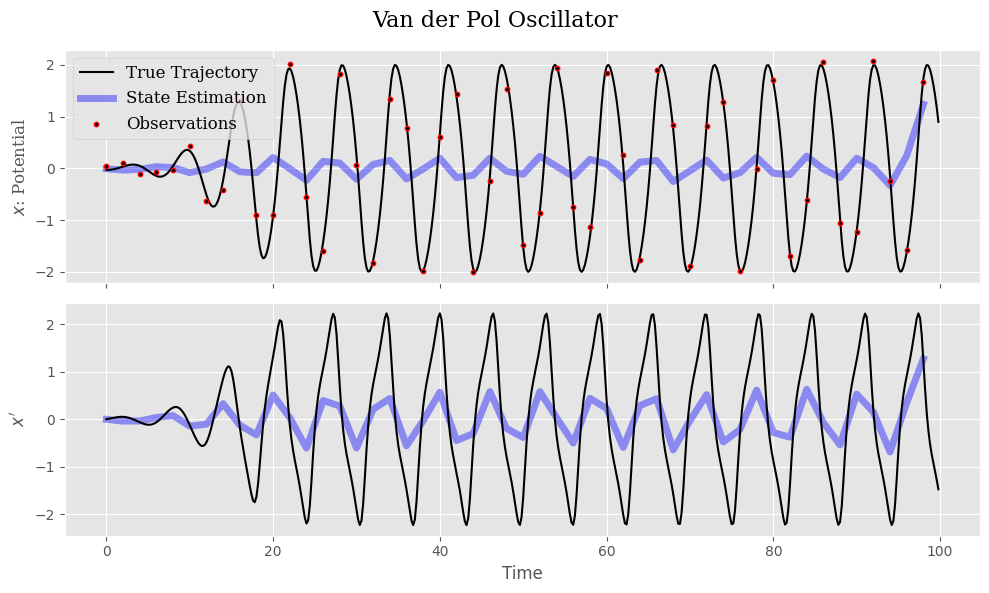

In [27]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], **TRUE_KW)
ax1.plot(t_train, trad_ho_model.differentiation_method.smoothed_x_, **EST_KW)
ax1.scatter(t_train, x_train[:,0], **OBS_KW)

ax1.set_ylabel(r"$x$: Potential", fontname=fontname,size=12)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], **TRUE_KW)
ax2.plot(t_train, trad_ho_model.differentiation_method(x_train[:, 0], np.array(t_train)), **EST_KW)

ax2.set_ylabel(r"$x'$", fontname=fontname,size=12)
ax2.set_xlabel("Time")
ax2.grid(True)
# ax2.legend(prop={'family': fontname, 'size':12})

plt.suptitle("Van der Pol Oscillator", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

In [28]:
def make_streamplot_arrs(rhs: Callable, X0, Y0) -> tuple[np.ndarray, np.ndarray]:
    """
    Parameters:

        X0, Y0: Meshgrid of support in x and y axes
    """
    U = np.zeros(X0.shape)
    V = np.zeros(Y0.shape)

    # Evaluate the vector field
    for i in tqdm(range(X0.shape[0])):
        for j in range(X0.shape[1]):
            arr = jnp.array([[X0[i, j], Y0[i, j]]])
            dxdt, dydt = rhs(0, arr)
            U[i, j] = dxdt
            V[i, j] = dydt

    # Normalize the arrows
    speed = np.sqrt(U**2 + V**2)
    U /= speed
    V /= speed

    return U, V

In [29]:
U_weak, V_weak = make_streamplot_arrs(weak_sindy_pred_tuple, X0, Y0)
U_trad, V_trad = make_streamplot_arrs(trad_sindy_pred_tuple, X0, Y0)

100%|██████████| 221/221 [00:59<00:00,  3.69it/s]
/tmp/ipykernel_765508/3705999270.py:20: RuntimeWarning: invalid value encountered in divide
  U /= speed
/tmp/ipykernel_765508/3705999270.py:21: RuntimeWarning: invalid value encountered in divide
  V /= speed
100%|██████████| 221/221 [01:55<00:00,  1.91it/s]
/tmp/ipykernel_765508/3705999270.py:20: RuntimeWarning: invalid value encountered in divide
  U /= speed
/tmp/ipykernel_765508/3705999270.py:21: RuntimeWarning: invalid value encountered in divide
  V /= speed


In [30]:
def trad_sindy_ode(t,x,args = None):
    x = np.reshape(x, (1, -1))
    return np.concat((np.array(x[:,1]), trad_ho_model.predict(x[:, :1], u=x[:,1:])[0]), axis=0)

def weak_sindy_ode(t,x,args = None):
    x=np.asarray(x).reshape((1, -1))
    feats = alt_ho_model.feature_library.function_library.transform(x)
    coeffs = alt_ho_model.coefficients()

    return np.concat((np.array(x[:, 1]), (feats @ coeffs.T).flatten()), axis=0)

def scipy_extend(rhs: Callable, t_extend: jax.Array, y0: jax.Array):
    return solve_ivp(rhs, (t_extend[0], t_extend[-1]), y0, t_eval=t_extend).y.T


trad_traj = []
weak_traj = []
for y0 in tqdm(initial_conditions):
    trad_traj.append(scipy_extend(trad_sindy_ode, t_true, y0))
    weak_traj.append(scipy_extend(weak_sindy_ode, t_true, y0))

100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


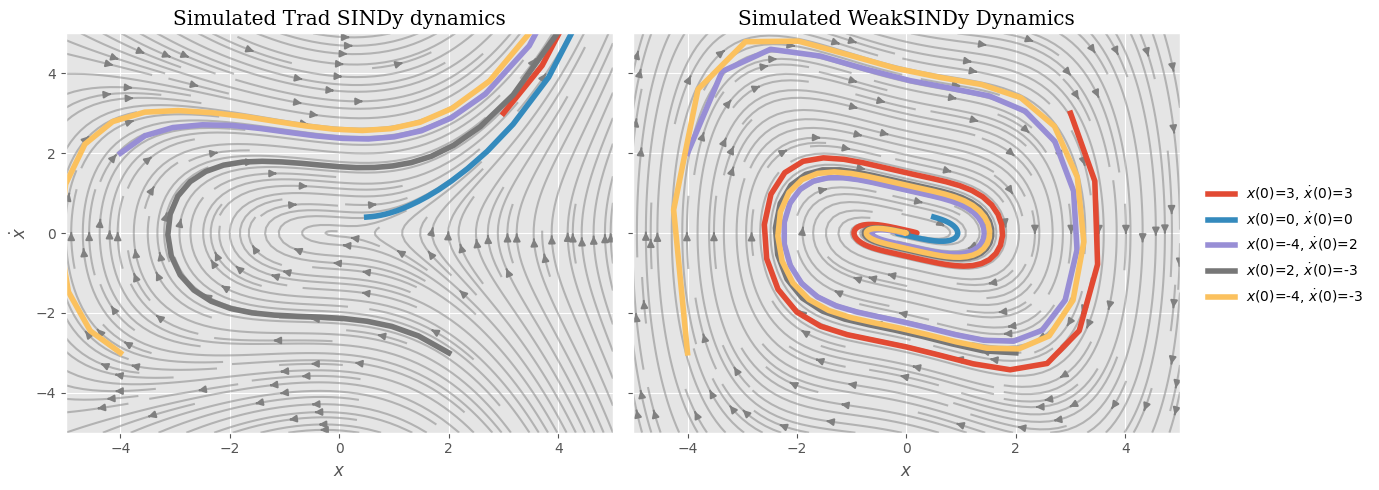

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5),sharey=True)
axs = axs.flatten()

sp0 = axs[0].streamplot(x_vals, y_vals, U_trad, V_trad, density=2, color='gray')
axs[0].set_ylabel(r"$\dot x$")
axs[0].set_xlabel(r"$x$")
axs[0].set_title("Simulated Trad SINDy dynamics",family='serif')

# Change alpha for both lines and arrows
sp0.lines.set_alpha(0.5)
sp0.arrows.set_alpha(0.5)

cutoff=-1
sp1 = axs[1].streamplot(x_vals, y_vals, U_weak, V_weak, density=2, color='gray')


# Plot trajectories 
for idx, (x_trad, x_weak) in enumerate(zip(trad_traj, weak_traj)):
    c=None
    ic = initial_conditions[idx]
    label = rf"$x(0)$={int(ic[0])}, $\dot x(0)$={int(ic[1])}"
    axs[0].plot(x_trad[:,0],x_trad[:,1],
                lw=4,zorder=2,c=c,label=label)

    axs[1].plot(x_weak[:cutoff,0],x_weak[:cutoff,1],
                lw=4,zorder=2,c=c)

axs[1].set_xlabel(r"$x$")
axs[1].set_title("Simulated WeakSINDy Dynamics", family='serif')

axs[0].set_xlim(x_min,x_max)
axs[1].set_xlim(x_min,x_max)

axs[0].set_ylim(y_min,y_max)
axs[1].set_ylim(y_min,y_max)


# Change alpha for both lines and arrows
sp1.lines.set_alpha(0.5)
sp1.arrows.set_alpha(0.5)


fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)

plt.tight_layout()
plt.savefig("vdp_sindy_phase.pdf", bbox_inches="tight")